In [118]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [119]:
CSV_PATH = 'customer_segmentation.csv' 
FEATURE_COLS = None

In [120]:

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Dataset not found at {CSV_PATH}. Put your CSV in the working directory or update CSV_PATH.")



In [121]:
df = pd.read_csv(CSV_PATH)
print('Dataset loaded — shape:', df.shape)

print('\nColumns:')
print(df.columns.tolist())


Dataset loaded — shape: (2240, 29)

Columns:
['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [122]:
print("\nFirst 5 rows:")
print(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)



First 5 rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \


In [123]:
if FEATURE_COLS is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if not c.lower().startswith('id')]
    FEATURE_COLS = numeric_cols

print("\nUsing columns for clustering:")
print(FEATURE_COLS)

if len(FEATURE_COLS) < 2:
    raise ValueError("Not enough numeric features found for clustering. Consider encoding categorical variables such as Gender.")



Using columns for clustering:
['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [124]:
if 'Gender' in df.columns and 'Gender' not in FEATURE_COLS:
    print("\nDetected Gender column — encoding and adding to features.")
    le = LabelEncoder()
    df['Gender_enc'] = le.fit_transform(df['Gender'].astype(str))
    FEATURE_COLS.append('Gender_enc')


In [125]:
X = df[FEATURE_COLS].copy()

if X.isnull().any().any():
    X = X.fillna(X.median())
    print("\nFilled missing values in features with median.")



Filled missing values in features with median.


In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

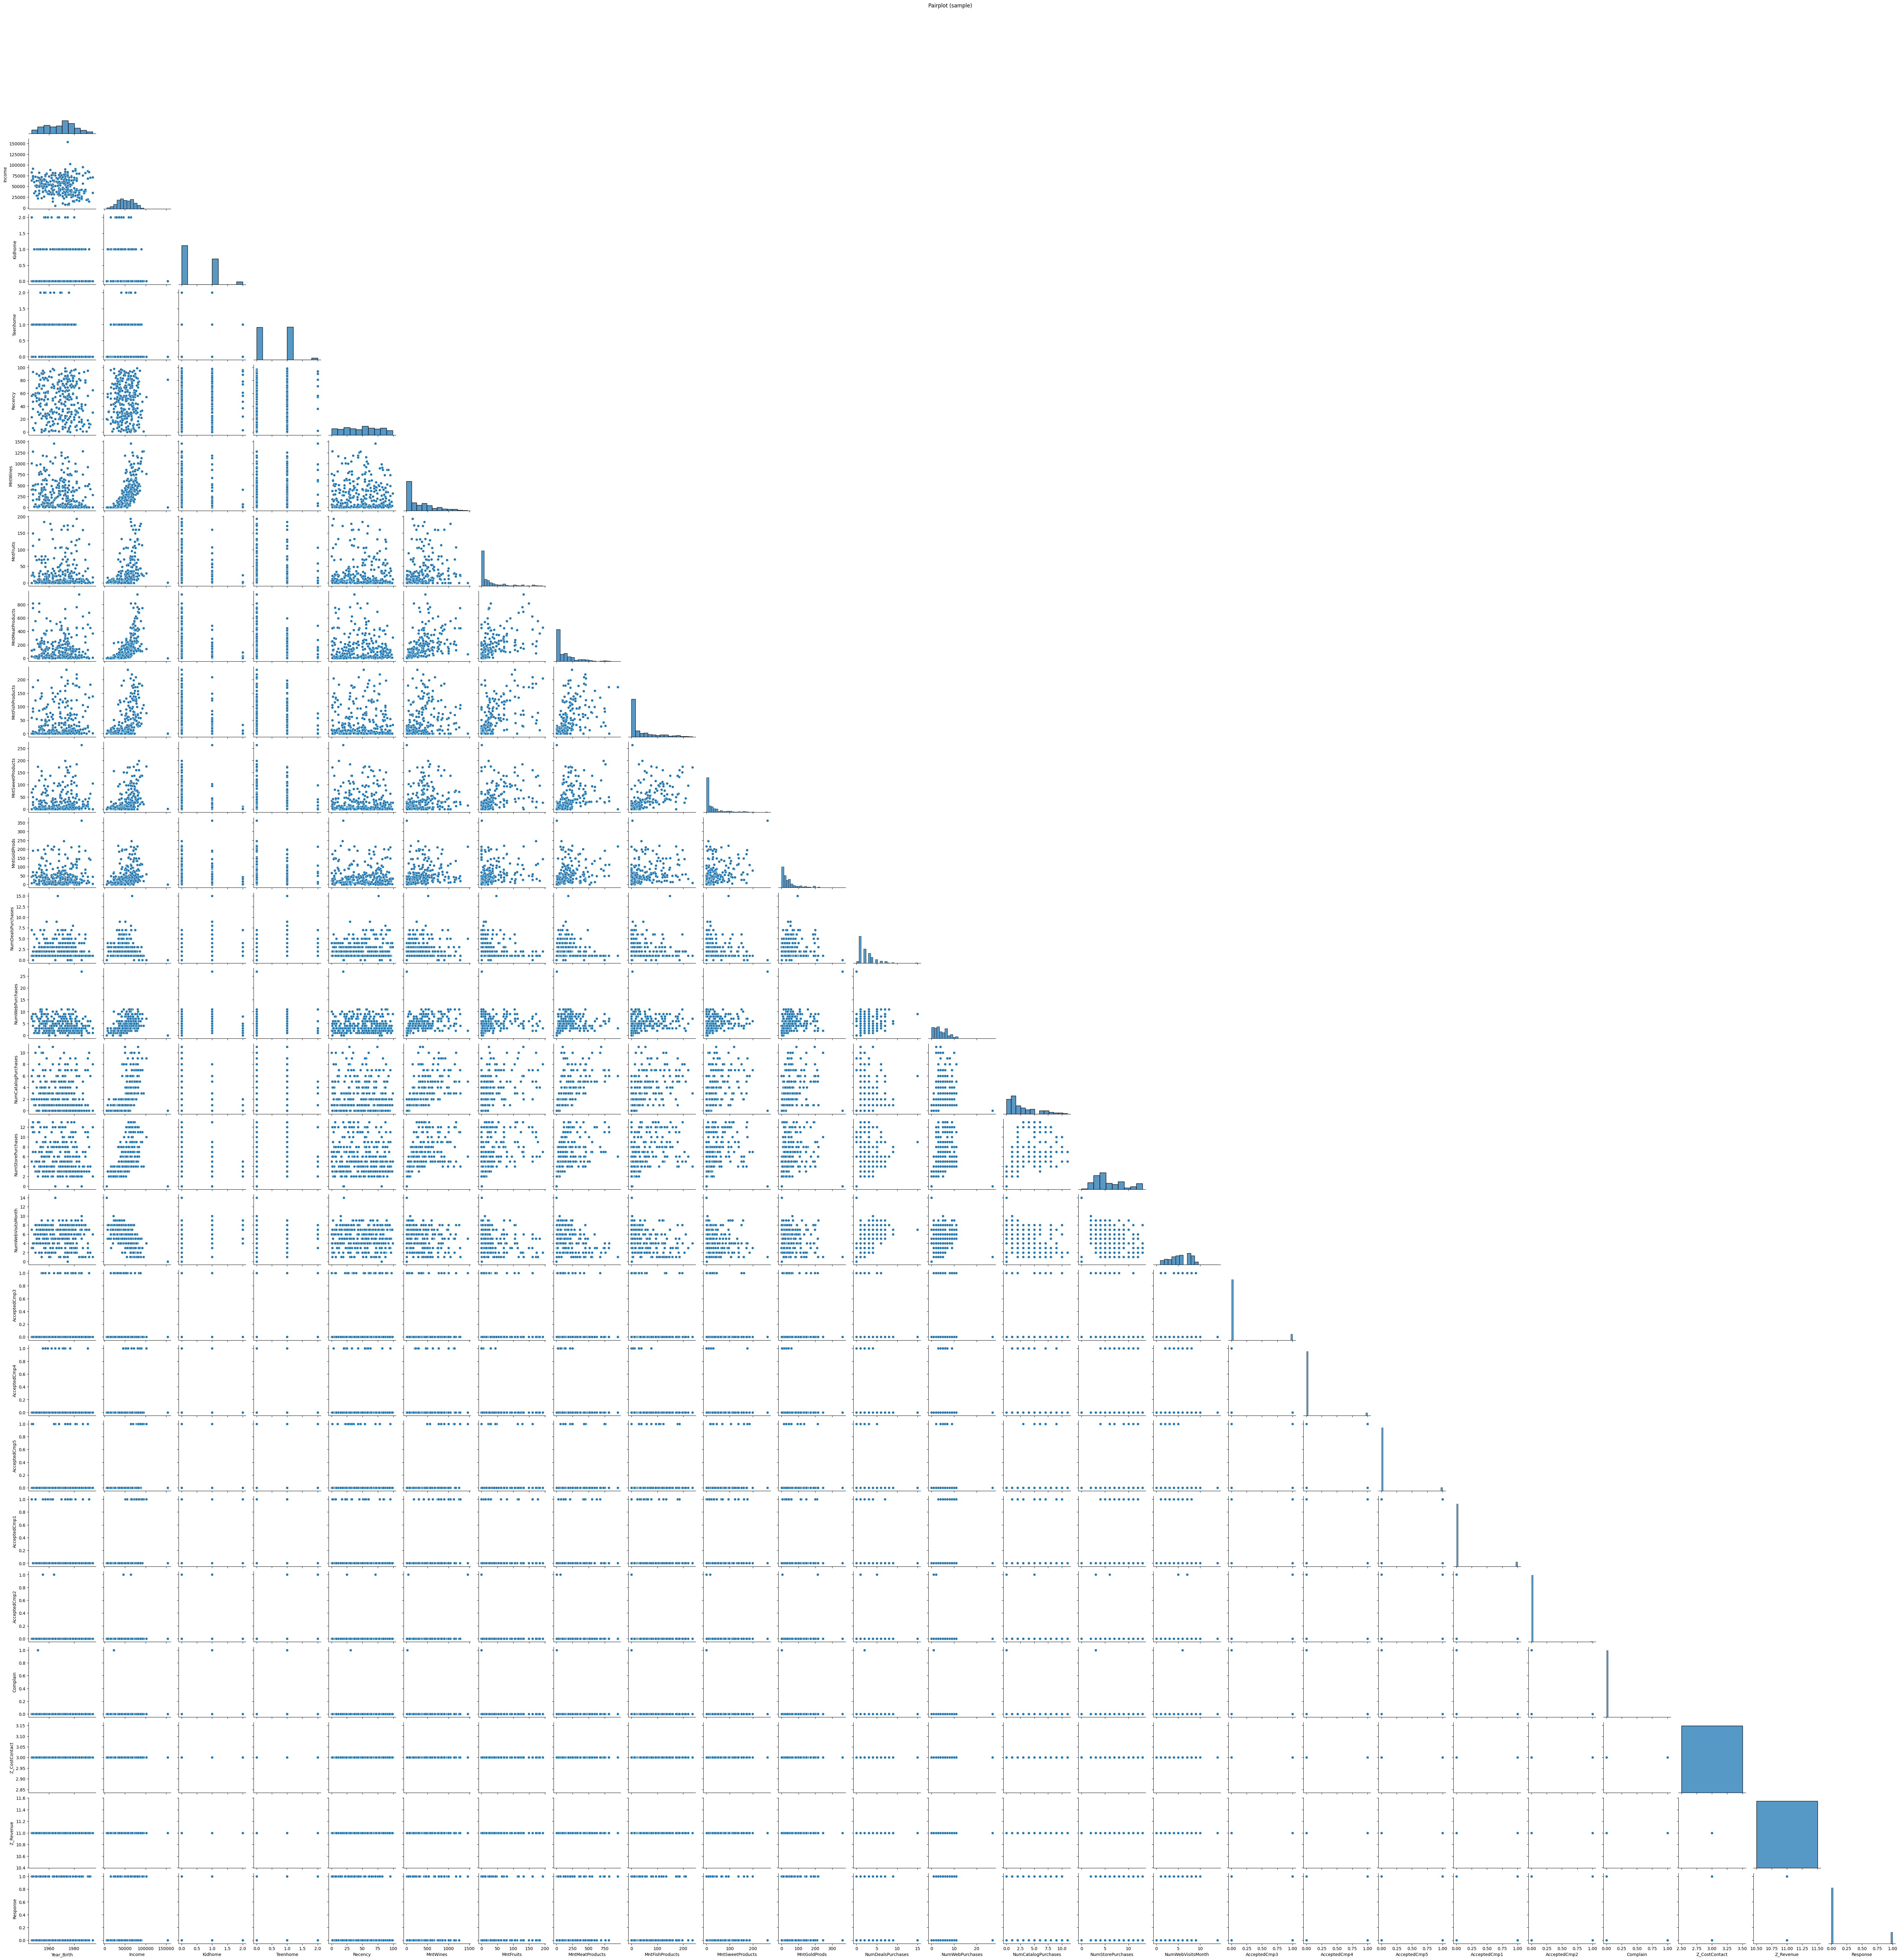

In [127]:
try:
    sns.pairplot(df[FEATURE_COLS].sample(min(300, len(df))), corner=True)
    plt.suptitle("Pairplot (sample)", y=1.02)
    plt.show()

except Exception as e:
    print("Pairplot could not be generated (probably too many points or missing numerical columns).")


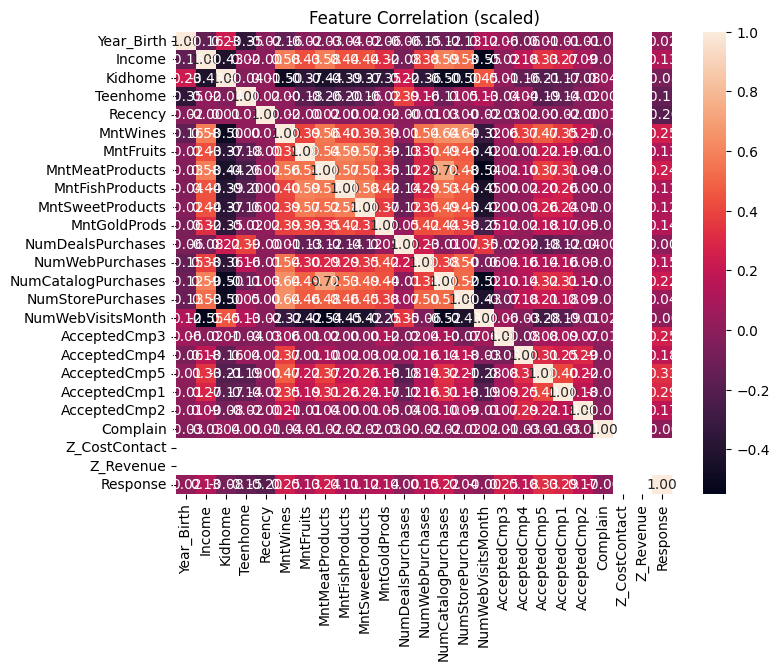

In [128]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(X_scaled, columns=FEATURE_COLS).corr(), annot=True, fmt='.2f')
plt.title('Feature Correlation (scaled)')
plt.show()

In [129]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("\nExplained variance by 2 PCA components:", pca.explained_variance_ratio_.sum())



Explained variance by 2 PCA components: 0.3712412235283293


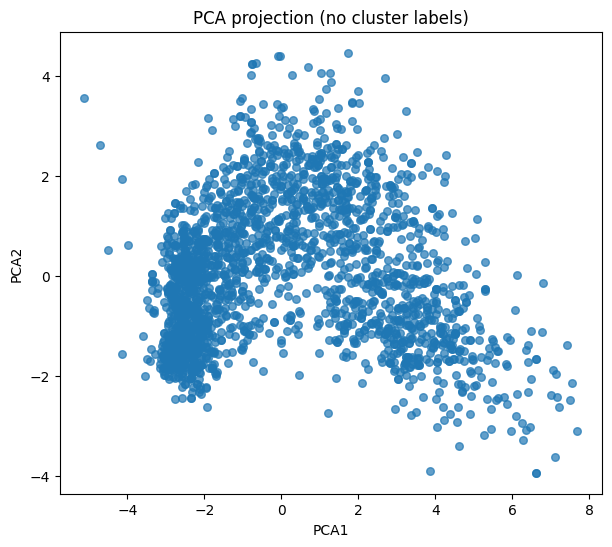

In [130]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=30, alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA projection (no cluster labels)')
plt.show()

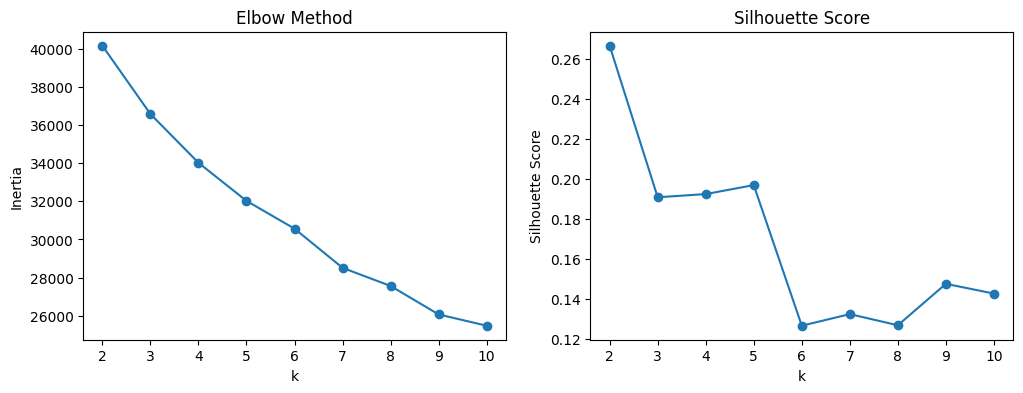

In [131]:
inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, "-o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, "-o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()


In [132]:
best_k = K_range[int(np.argmax(sil_scores))]
print(f'Best k by silhouette score: {best_k}')


kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)


df['Cluster'] = cluster_labels

Best k by silhouette score: 2


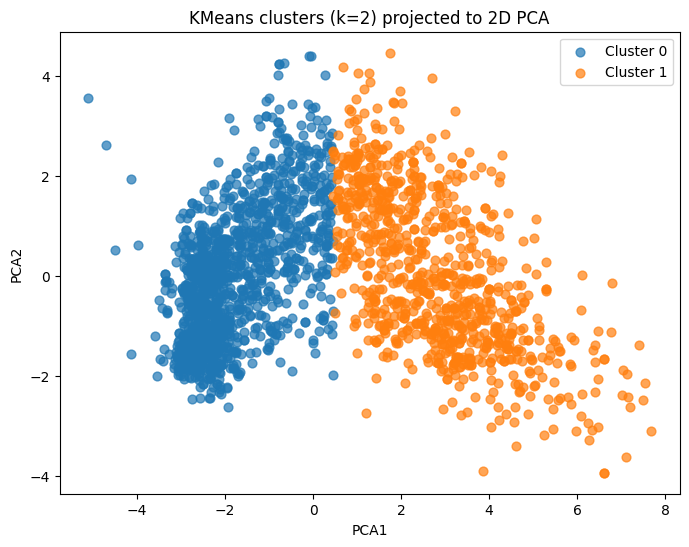

In [133]:
plt.figure(figsize=(8,6))

for c in np.unique(cluster_labels):
    mask = df['Cluster'] == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {c}', s=40, alpha=0.7)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title(f'KMeans clusters (k={best_k}) projected to 2D PCA')
plt.show()


In [134]:
profile = df.groupby('Cluster')[FEATURE_COLS].agg(['count', 'mean', 'median']).round(2)

print("\nCluster profiles (count, mean, median):")
print(profile)

cluster_counts = df['Cluster'].value_counts().sort_index()

print("\nCluster counts:")
print(cluster_counts)



Cluster profiles (count, mean, median):
        Year_Birth                  Income                    Kidhome        \
             count     mean  median  count      mean   median   count  mean   
Cluster                                                                       
0             1361  1969.93  1971.0   1345  39164.35  38547.0    1361  0.69   
1              879  1967.06  1967.0    871  72449.90  71706.0     879  0.07   

               Teenhome  ... Complain Z_CostContact             Z_Revenue  \
        median    count  ...   median         count mean median     count   
Cluster                  ...                                                
0          1.0     1361  ...      0.0          1361  3.0    3.0      1361   
1          0.0      879  ...      0.0           879  3.0    3.0       879   

                     Response               
         mean median    count  mean median  
Cluster                                     
0        11.0   11.0     1361  0.09    0.0

In [135]:
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.joblib'))
joblib.dump(kmeans_final, os.path.join(MODEL_DIR, 'kmeans.joblib'))
joblib.dump(pca, os.path.join(MODEL_DIR, 'pca.joblib'))

print(f"\nSaved scaler, kmeans, and pca to {MODEL_DIR}")



Saved scaler, kmeans, and pca to models


In [136]:
def predict_cluster(new_df):
    """
    new_df: pd.DataFrame with same FEATURE_COLS columns (or subset if encoded)
    returns: cluster label and PCA coordinates
    """
    
    X_new = new_df[FEATURE_COLS].copy()
    X_new = X_new.fillna(X_new.median())
    
    X_new_scaled = scaler.transform(X_new)
    labels = kmeans_final.predict(X_new_scaled)
    pca_coords = pca.transform(X_new_scaled)
    
    out = new_df.copy()
    out['Cluster'] = labels
    out['PCA1'] = pca_coords[:, 0]
    out['PCA2'] = pca_coords[:, 1]
    
    return out


In [137]:
OUTPUT_CSV = 'customer_segments_with_labels.csv'
df.to_csv(OUTPUT_CSV, index=False)
print(f'Wrote clustered dataset to {OUTPUT_CSV}')

Wrote clustered dataset to customer_segments_with_labels.csv


In [138]:
print("\nNotebook complete. Review chosen features and clustering results; adjust FEATURE_COLS as needed for business meaning.")



Notebook complete. Review chosen features and clustering results; adjust FEATURE_COLS as needed for business meaning.
